In [29]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Activation, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [31]:
BATCH_SIZE = 8
LR = 0.001
EPOCH = 50
height = 512
width = 512
n_classes = 12

In [32]:
image_names = glob.glob("/content/drive/My Drive/dataset/cityscapes/data/train/*.png")
image_names.sort()
images = [cv2.imread(image,0) for image in image_names ]
resized_images = [cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST) for image in images]
image_dataset = np.array(resized_images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [33]:
mask_names = glob.glob("/content/drive/My Drive/dataset/cityscapes/data/trainannot/*.png")
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
resized_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) for mask in masks]
mask_dataset = np.array(resized_masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)


In [34]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (367, 256, 256, 1)
Mask data shape is:  (367, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [35]:
#normalize images

image_dataset = image_dataset /255

In [36]:
#split training data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 42)

In [37]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [38]:
print(y_train_cat.shape)

(293, 256, 256, 12)


BUILD UNET

In [39]:
# double conv

def conv_block(inputs, num_filters):
  x= Conv2D(num_filters, 3, padding="same")(inputs)
  x= BatchNormalization()(x)
  x= Activation("relu")(x)

  x= Conv2D(num_filters, 3, padding="same")(x)
  x= BatchNormalization()(x)
  x= Activation("relu")(x)
  return x

In [40]:
#encoder

def encoder_block(inputs, num_filters):
  x= conv_block(inputs, num_filters)
  p= MaxPool2D((2, 2))(x)
  return x, p

In [41]:
#decoder

def decoder_block(inputs, skip, num_filters):
  x= Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
  x= Concatenate()([x, skip])
  x= conv_block(x, num_filters)
  return x

In [42]:
# UNET

def unet(input_shape, n_classes):
  inputs = Input(input_shape)
#encoder
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)
#bottleneck
  b1 = conv_block(p4, 1024)
#decoder
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)

  model = Model(inputs, outputs, name="UNET")
  return model

In [43]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [44]:
model = unet(input_shape, n_classes=12)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

In [45]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 2,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/100
147/147 [==============================] - 43s 160ms/step - loss: 1.0727 - accuracy: 0.6536 - val_loss: 15.2090 - val_accuracy: 0.3089
Epoch 2/100
147/147 [==============================] - 23s 153ms/step - loss: 0.8934 - accuracy: 0.6999 - val_loss: 8.0020 - val_accuracy: 0.3089
Epoch 3/100
147/147 [==============================] - 23s 159ms/step - loss: 0.8057 - accuracy: 0.7323 - val_loss: 4.4210 - val_accuracy: 0.3267
Epoch 4/100
147/147 [==============================] - 23s 157ms/step - loss: 0.7576 - accuracy: 0.7504 - val_loss: 1.3995 - val_accuracy: 0.5298
Epoch 5/100
147/147 [==============================] - 23s 157ms/step - loss: 0.7102 - accuracy: 0.7688 - val_loss: 0.9660 - val_accuracy: 0.6913
Epoch 6/100
147/147 [==============================] - 23s 158ms/step - loss: 0.6732 - accuracy: 0.7838 - val_loss: 0.8131 - val_accuracy: 0.7454
Epoch 7/100
147/147 [==============================] - 23s 156ms/step - loss: 0.6441 - accuracy: 0.7946 - val_loss: 0.8788 

In [46]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/project3_UNET.hdf5')

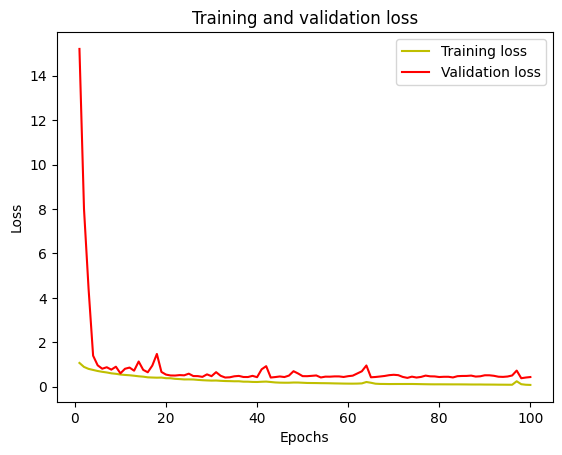

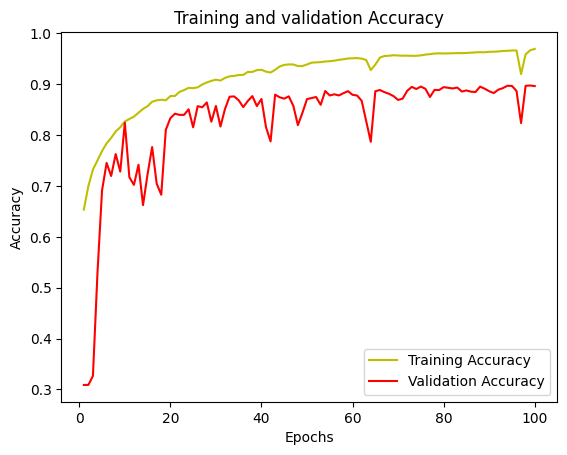

In [47]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)


y_pred=model.predict(X_test)


y_pred.shape

3/3 [==============================] - 1s 514ms/step


(74, 256, 256, 12)

In [49]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(74, 256, 256)

In [50]:
from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.5765518


1/1 [==============================] - 0s 28ms/step


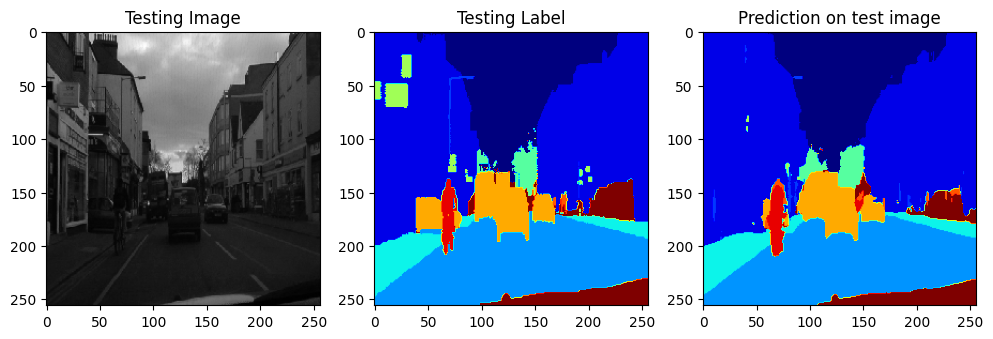

In [51]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()